In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from scipy.interpolate import make_interp_spline
from pathlib import Path

# Set matplotlib style for minimal design
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False
from matplotlib.patches import Rectangle


In [7]:
def load_single_image(image_path):
    img = Image.open(image_path)
    frame = np.array(img.convert('L'))
    return frame


def calculate_projections(roi, axis=0):
    projection_raw = np.sum(roi, axis=axis).astype(np.float32)
    return projection_raw


def smooth_data(x, y, smoothing_factor=300):
    if len(x) < 4:
        return x, y

    if smoothing_factor <= len(x):
        smoothing_factor = len(x) * 2

    x_smooth = np.linspace(x.min(), x.max(), smoothing_factor)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_smooth)

    return x_smooth, y_smooth


In [8]:
def analyze_three_channel_images(channel_configs, apply_smoothing=True, smoothing_factor=300, save_path=None, fig_width=6, fig_height=4, plot_title=None, y_upper_margin=100):
    if len(channel_configs) != 3:
        raise ValueError("channel_configs must contain exactly three entries for Pre-bleach, Post-bleach, and Post-recovery.")

    # Visualization and axis settings
    data_length_um = 8.0   # data region spans 0-8 μm
    x_offset = 1.0         # shift so the 0 label sits one tick away from origin
    axis_pad = 2.0         # extra space after data region
    tick_step = 1.0        # tick spacing on x-axis (thin ticks)
    y_tick_step = 200      # tick spacing on y-axis

    # Bleached region overlay settings
    bleached_start = 3.0   # in μm (before x_offset)
    bleached_end = 10.0    # in μm (before x_offset)
    bleached_alpha = 0.2
    bleached_color = "#84888f"

    axis_end = x_offset + data_length_um + axis_pad

    channel_data = []
    max_y = 0.0

    for config in channel_configs:
        label = config.get('label')
        path = config.get('path')
        if not label or not path:
            raise ValueError("Each channel config must include 'label' and 'path'.")

        image = load_single_image(path)
        print(f"{label} image shape: {image.shape}")

        projection_raw = calculate_projections(image, axis=0)
        if projection_raw.size:
            max_y = max(max_y, projection_raw.max())

        if len(projection_raw) >= 2:
            x_vals = np.linspace(0, data_length_um, len(projection_raw)) + x_offset
        else:
            x_vals = np.array([], dtype=np.float32)

        if apply_smoothing and len(x_vals) >= 4:
            x_plot, y_plot = smooth_data(x_vals, projection_raw, smoothing_factor)
        else:
            x_plot, y_plot = x_vals, projection_raw

        channel_data.append({
            'label': label,
            'raw': projection_raw,
            'normalized': projection_raw,
            'plot_x': x_plot,
            'plot_y': y_plot,
            'color': config.get('color', '#B200F4'),
            'linestyle': config.get('linestyle', '-')
        })

    if max_y <= 0:
        max_y = 1.0

    # Build y ticks every 200 with labels
    y_max_plot = np.ceil(max_y / y_tick_step) * y_tick_step
    y_ticks = np.arange(0, y_max_plot + y_tick_step, y_tick_step)
    y_limit = y_max_plot + y_upper_margin

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    for channel in channel_data:
        x_plot = channel['plot_x']
        y_plot = channel['plot_y']

        if len(x_plot) == 0:
            continue

        ax.plot(
            x_plot,
            y_plot,
            label=channel['label'],
            color=channel['color'],
            linewidth=2,
            linestyle=channel['linestyle']
        )

    # Bleached region overlay
    b_start_disp = bleached_start + x_offset
    b_end_disp = bleached_end + x_offset
    ax.add_patch(
        Rectangle(
            (b_start_disp, 0),
            b_end_disp - b_start_disp,
            y_limit,
            facecolor=bleached_color,
            alpha=bleached_alpha,
            edgecolor='none'
        )
    )
    ax.text(
        b_start_disp + (b_end_disp - b_start_disp) / 2.0,
        y_limit * 0.98,
        'bleached region',
        ha='center',
        va='top',
        fontsize=16,
        color="#000000",
        alpha=1
    )

    ax.set_xlim(0, axis_end)
    x_ticks = np.arange(0, axis_end + tick_step, tick_step)
    x_tick_labels = []
    for t in x_ticks:
        label_value = t - x_offset
        if label_value >= -1e-6 and np.isclose(label_value % 5, 0.0, atol=1e-6):
            x_tick_labels.append(str(int(round(label_value))))
        else:
            x_tick_labels.append('')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    ax.set_ylim(0, y_limit)
    ax.set_yticks(y_ticks)

    ax.set_xlabel('Length (μm)', fontsize=16)
    ax.set_ylabel('Intensity (a.u.)', fontsize=16)
    title_text = plot_title if plot_title is not None else 'Intensity profile'
    ax.set_title(title_text, loc='left', fontsize=18, pad=10)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False, fontsize=10)

    # Different tick lengths for labeled vs unlabeled ticks
    for tick, lbl in zip(ax.xaxis.get_major_ticks(), ax.get_xticklabels()):
        if lbl.get_text():
            tick.tick1line.set_markersize(8)
            tick.tick2line.set_markersize(8)
        else:
            tick.tick1line.set_markersize(4)
            tick.tick2line.set_markersize(4)

    ax.tick_params(axis='x', labelsize=14, width=2, length=4)
    ax.tick_params(axis='y', labelsize=14, width=2, length=8)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    return channel_data


In [9]:
def save_projections_to_csv(channel_results, save_path):
    if not channel_results:
        raise ValueError("channel_results cannot be empty.")

    max_points = max(len(channel['raw']) for channel in channel_results)

    raw_headers = [f"{channel['label'].replace(' ', '_')}_raw" for channel in channel_results]
    norm_headers = [f"{channel['label'].replace(' ', '_')}_normalized" for channel in channel_results]

    with open(save_path, 'w') as f:
        f.write(",".join(raw_headers + [''] + norm_headers) + "\n")
        for idx in range(max_points):
            row_raw = []
            row_norm = []
            for channel in channel_results:
                if idx < len(channel['raw']):
                    row_raw.append(f"{channel['raw'][idx]:.5f}")
                    row_norm.append(f"{channel['normalized'][idx]:.5f}")
                else:
                    row_raw.append("")
                    row_norm.append("")

            f.write(",".join(row_raw + [''] + row_norm) + "\n")

    print(f"CSV saved to: {save_path}")


Pre-bleach image shape: (10, 95)
Post-bleach image shape: (9, 97)
Post-recovery image shape: (9, 90)
Plot saved to: 04_FigS3F_plot_output/FigS3F_mBaojin.svg


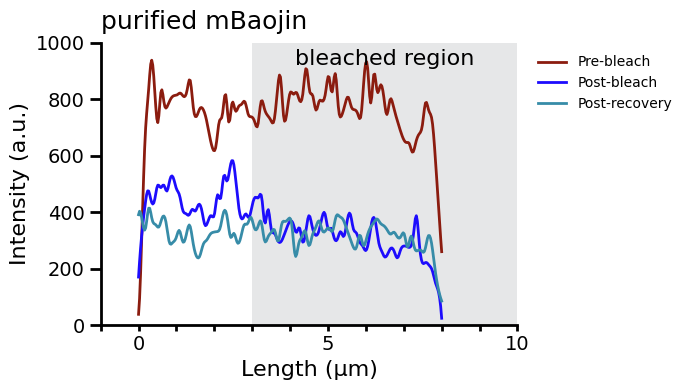

CSV saved to: 04_FigS3F_plot_output/FigS3F_mBaojin.csv


In [10]:
# Set Straighten image paths for each state
path_pre_bleach = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t01c1_c1_mBaojin_straight.tif")
path_post_bleach = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t02c1_c1_mBaojin_straight.tif")
path_post_recovery = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t43c1_c1_mBaojin_straight.tif")

# Set output file paths
svg_output_path = Path("04_FigS3F_plot_output/FigS3F_mBaojin.svg")
csv_output_path = Path("04_FigS3F_plot_output/FigS3F_mBaojin.csv")

# Configure channel styles
channel_configs = [
    {
        'label': 'Pre-bleach',
        'path': path_pre_bleach,
        'color': "#8B1C0F",
        'linestyle': '-'
    },
    {
        'label': 'Post-bleach',
        'path': path_post_bleach,
        'color': "#1D0CFD",
        'linestyle': '-'
    },
    {
        'label': 'Post-recovery',
        'path': path_post_recovery,
        'color': '#378CA8',
        #'color': '#B200F4',
        'linestyle': '-'
    }
]

channel_results = analyze_three_channel_images(
    channel_configs=channel_configs,
    apply_smoothing=True,
    smoothing_factor=300,
    save_path=svg_output_path,
    plot_title='purified mBaojin',
    fig_width=7,
    fig_height=4,
    y_upper_margin=0
)

save_projections_to_csv(channel_results, csv_output_path)


Pre-bleach image shape: (10, 95)
Post-bleach image shape: (9, 97)
Post-recovery image shape: (9, 90)
Plot saved to: 04_FigS3F_plot_output/FigS3F_membrane.svg


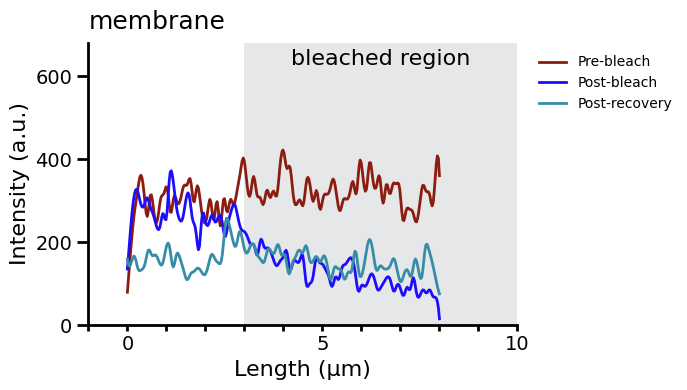

CSV saved to: 04_FigS3F_plot_output/FigS3F_membrane.csv


In [11]:
# Set Straighten image paths for each state
path_pre_bleach = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t01c2_c2_membrane_straight.tif")
path_post_bleach = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t02c2_c2_membrane_straight.tif")
path_post_recovery = Path("02_FigS3F_straightener_output/Half-frap-1118-5-nobox_t43c2_c2_membrane_straight.tif")

# Set output file paths
svg_output_path = Path("04_FigS3F_plot_output/FigS3F_membrane.svg")
csv_output_path = Path("04_FigS3F_plot_output/FigS3F_membrane.csv")

# Configure channel styles
channel_configs = [
    {
        'label': 'Pre-bleach',
        'path': path_pre_bleach,
        'color': "#8B1C0F",
        'linestyle': '-'
    },
    {
        'label': 'Post-bleach',
        'path': path_post_bleach,
        'color': "#1D0CFD",
        'linestyle': '-'
    },
    {
        'label': 'Post-recovery',
        'path': path_post_recovery,
        'color': '#378CA8',
        #'color': '#B200F4',
        'linestyle': '-'
    }
]

channel_results = analyze_three_channel_images(
    channel_configs=channel_configs,
    apply_smoothing=True,
    smoothing_factor=300,
    save_path=svg_output_path,
    plot_title='membrane',
    fig_width=7,
    fig_height=4,
    y_upper_margin=80
)

save_projections_to_csv(channel_results, csv_output_path)
